In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import mean_absolute_error, mean_squared_error

import shap

import warnings
warnings.filterwarnings('ignore')

def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y):
    
    predictions = model.predict(X)

    MAE = mean_absolute_error(y, predictions)
    MAPE = mean_absolute_percentage_error(y, predictions)
    RMSE = mean_squared_error(y, predictions, squared = False)

    print('MAE for', model_name, ': %1.3f' % MAE)
    print('MAPE for', model_name, ': %1.3f' % MAPE)
    print('RMSE for', model_name, ': %1.3f' % RMSE)

    metrics_table = pd.DataFrame({'MAE' : [round(MAE, 3)], 'MAPE' : [round(MAPE, 3)], 'RMSE' : [round(RMSE, 3)]}, index = [model_name])
    
    return metrics_table

In [2]:
model_comparison = pd.read_csv('../../data/laptops/model_comparison.csv', )
model_comparison.rename(columns = {'Unnamed: 0' : 'Model'}, inplace = True)

In [4]:
model_comparison = model_comparison.sort_values('RMSE')

#model_comparison['ML class'] = ['Boosted Trees', 'Boosted Trees', 'Boosted Trees', 'Boosted Trees', 'Random Forest', 'SVM', 'SVM', 'Decision Tree', 'Neighbors',
#                                'Linear Regression', 'Penalized Linear Regression', 'Penalized Linear Regression', 'Penalized Linear Regression', 'SVM', 'Boosted Trees', 'Neighbors', 'Dummy', 'Dummy']

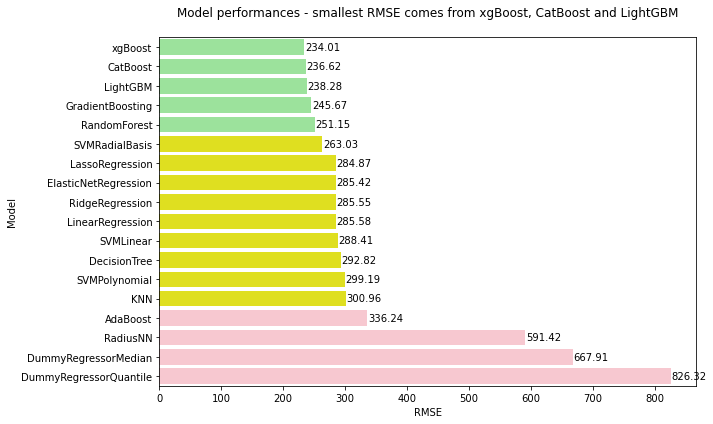

In [7]:
fig, ax = plt.subplots(figsize = (10, 6))

g = sns.barplot(x = 'RMSE', y = 'Model', data = model_comparison, ax = ax,
                palette = ['lightgreen' if (x < 260) else ('yellow' if (x < 301) else 'pink') for x in model_comparison['RMSE']])

for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 1, p.get_y() + p.get_height() / 2, 
            '{:1.2f}'.format(width), ha = 'left', va = 'center', size = 10) 
    
plt.title('Model performances - smallest RMSE comes from xgBoost, CatBoost and LightGBM\n')
plt.tight_layout()
plt.show()

xgBoost, CatBoost and LightGBM seem to have the best performance on test data, having the lowest RMSE error metrics among all models. I'll use SHAP to interpret and explain what the xgBoost algo does

In [15]:
# one hot encoded Xs
X_train = pd.read_csv('../../data/laptops/X_train.csv')
X_test = pd.read_csv('../../data/laptops/X_test.csv')

#Ys
y_train = np.array(pd.read_csv('../../data/laptops/y_train.csv'))
y_test = np.array(pd.read_csv('../../data/laptops/y_test.csv'))

### Explaining CatBoost model's feature importances, dependencies and effects

In [10]:
pkl_filename = 'saved_models/XGBoost.pkl'

with open(pkl_filename, 'rb') as file:
    xgBoost = pickle.load(file)

Re-evaluate preformance on test set

In [16]:
evaluate_model('xgBoost', xgBoost, X_test, y_test)

MAE for xgBoost : 157.270
MAPE for xgBoost : 82.830
RMSE for xgBoost : 234.011


,MAE,MAPE,RMSE
xgBoost,157.27,82.83,234.011


#### Use SHAP values to interpret model

In [20]:
shap.initjs()

In [21]:
xgb_explainer = shap.TreeExplainer(xgBoost)
xgb_shap_values = xgb_explainer.shap_values(X_train)

#### 1. Variable Importances

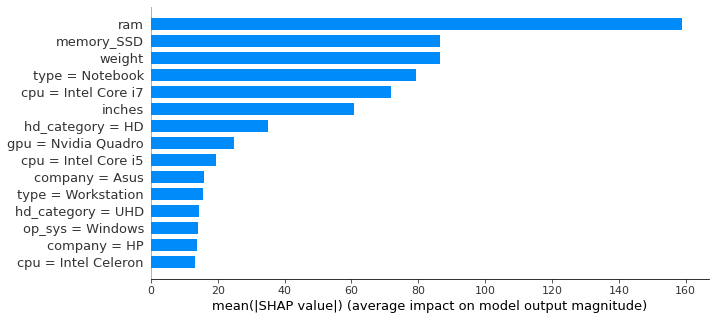

In [23]:
shap.summary_plot(xgb_shap_values, X_train, plot_type = 'bar', plot_size = (10, 5), max_display = 15)

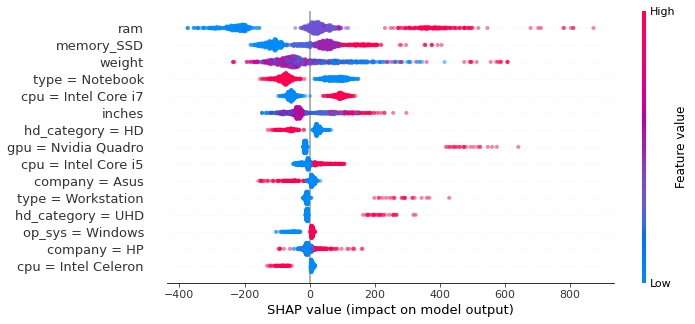

In [25]:
shap.summary_plot(xgb_shap_values, X_train, plot_type = 'dot', plot_size = (10, 5), alpha = 1/2, max_display = 15)

#### 2. Dependence plots

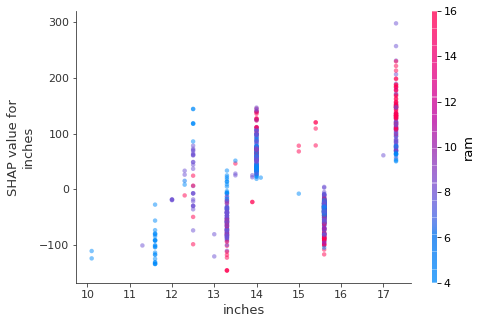

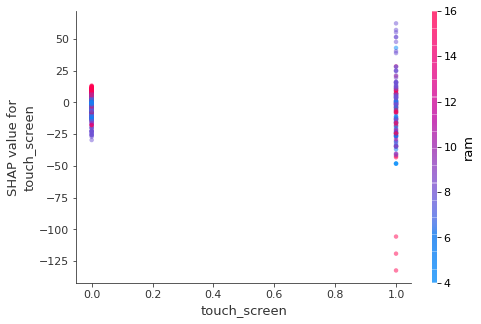

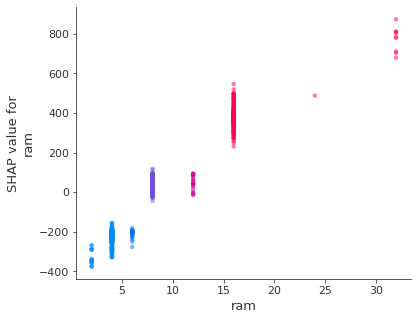

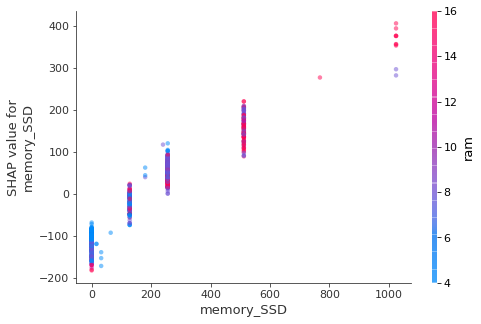

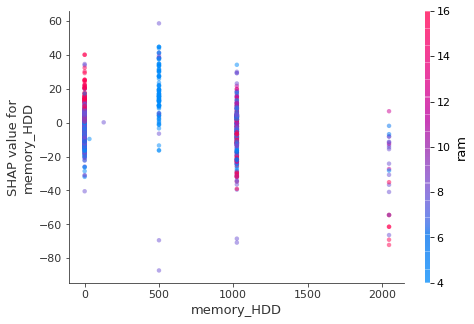

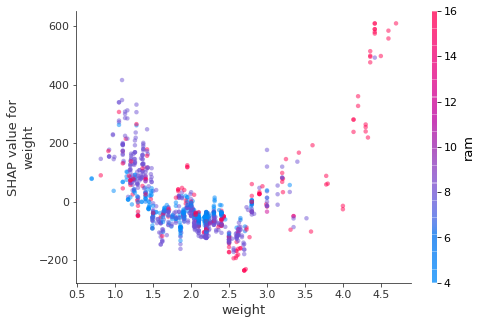

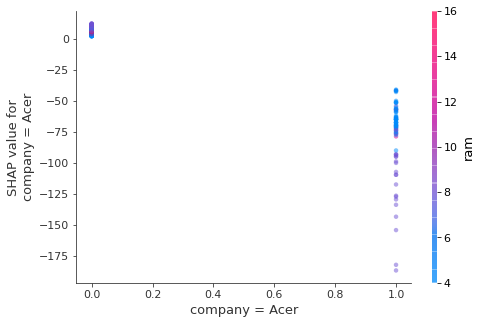

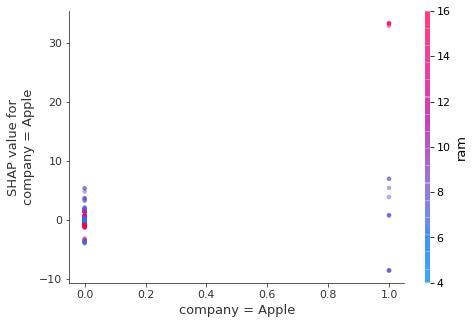

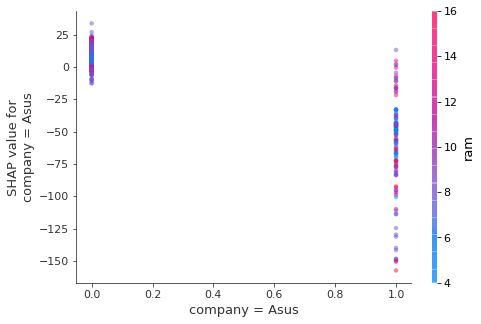

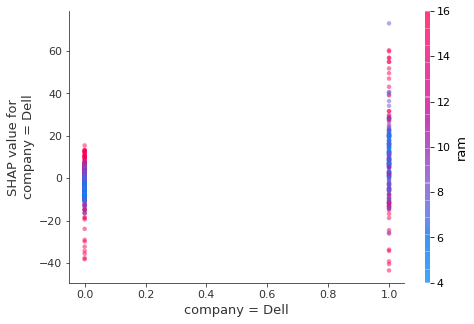

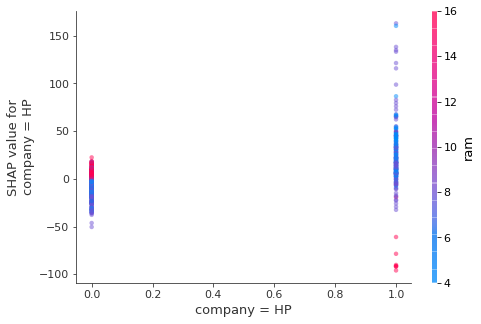

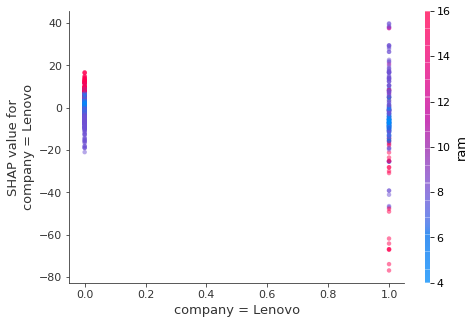

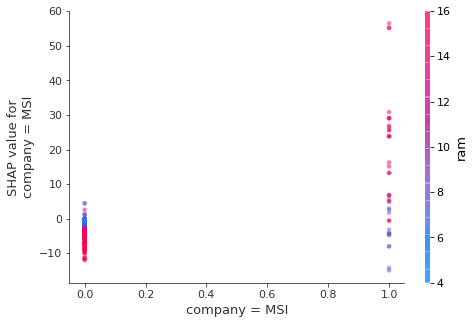

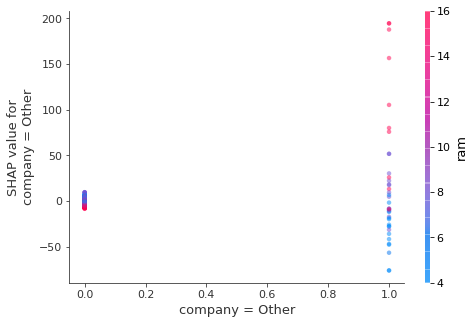

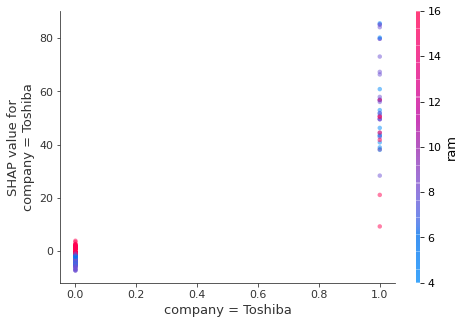

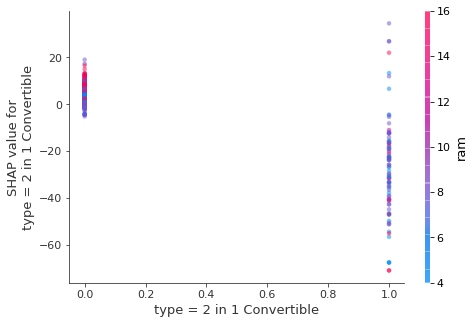

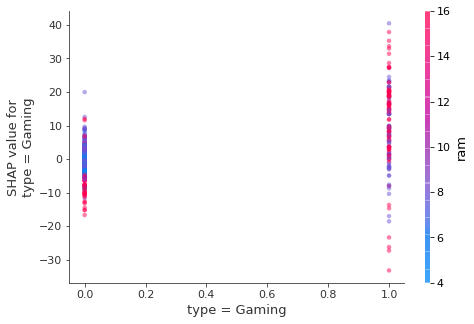

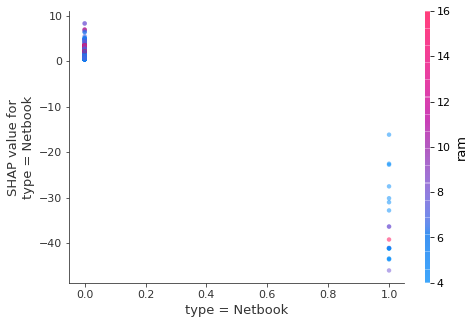

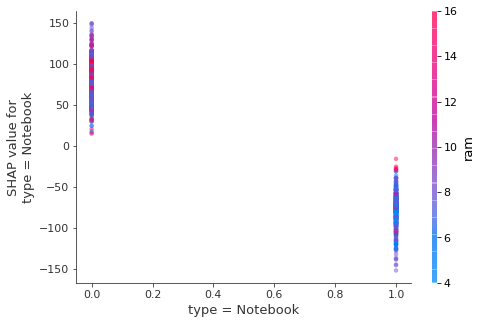

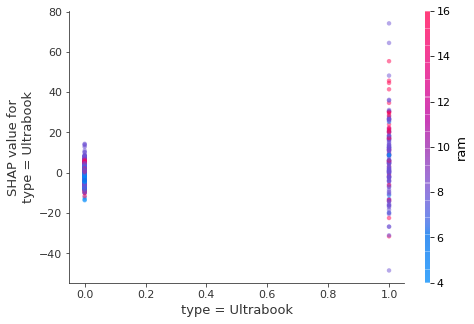

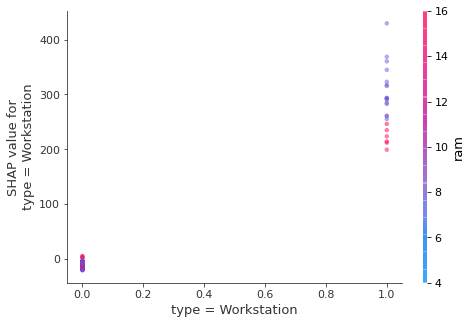

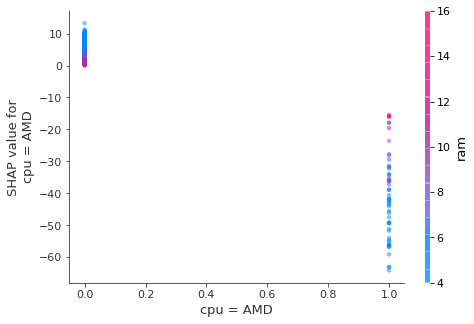

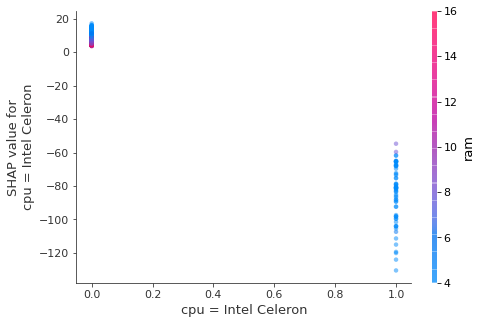

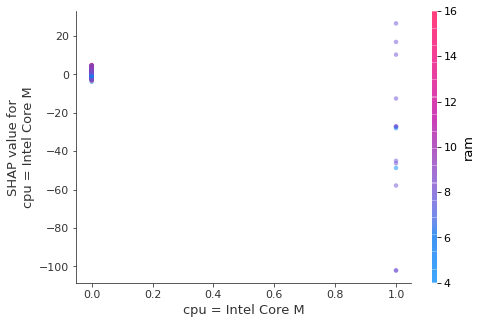

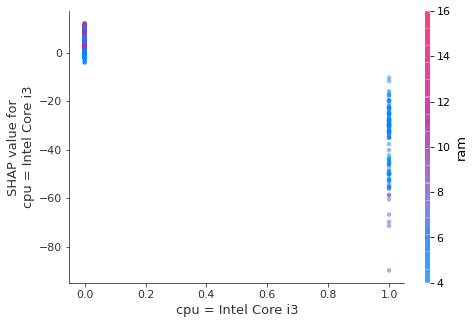

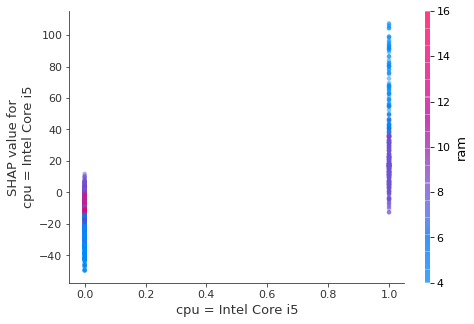

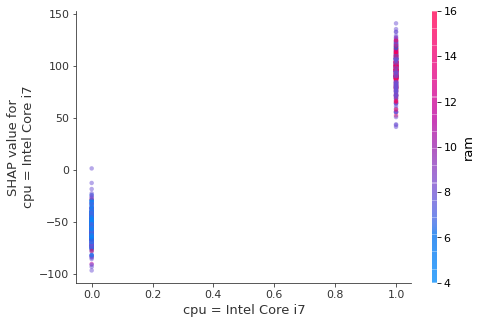

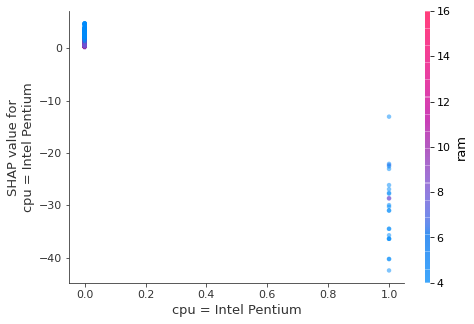

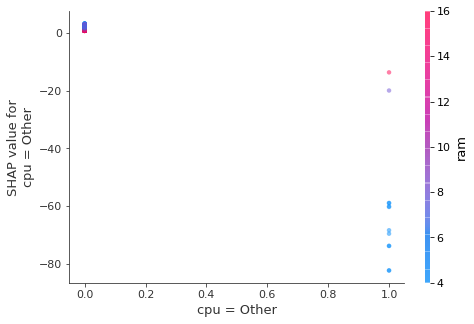

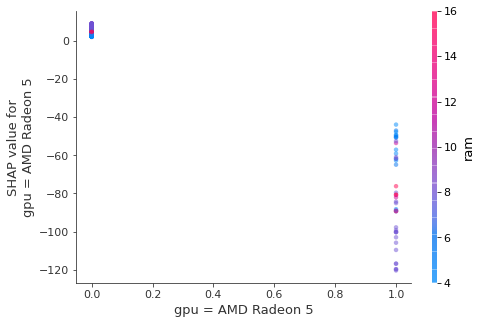

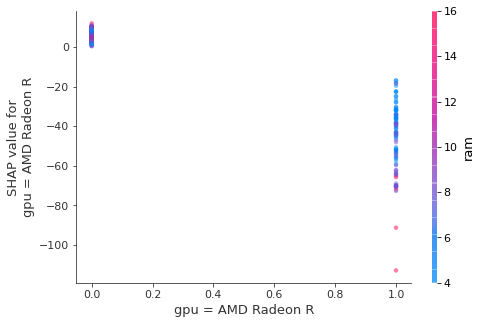

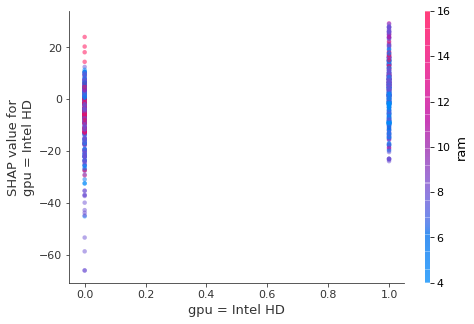

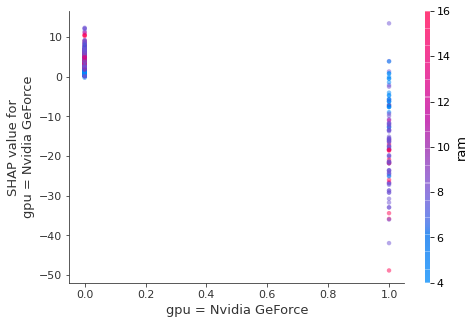

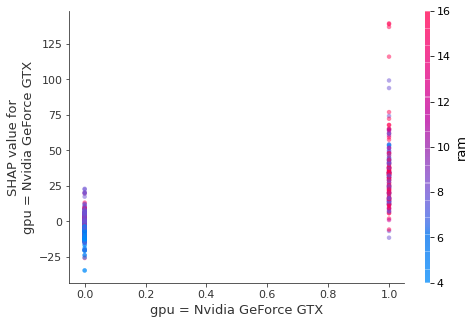

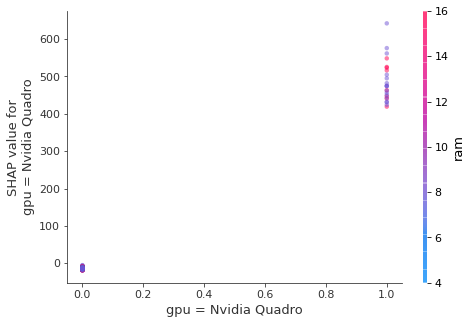

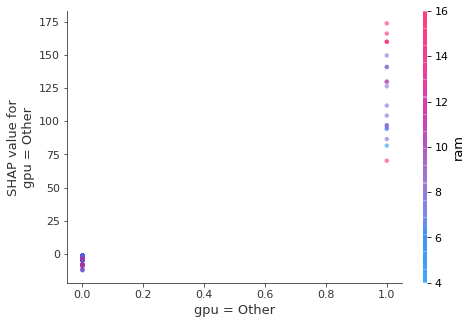

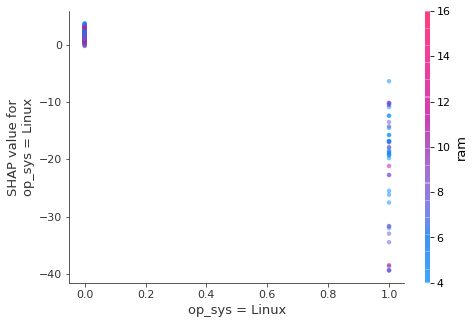

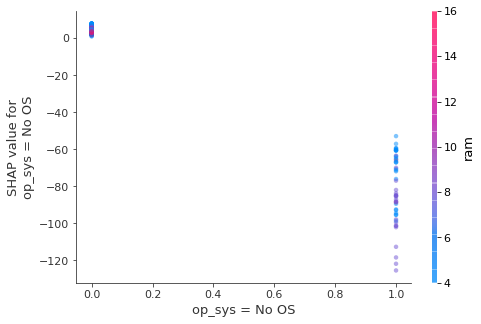

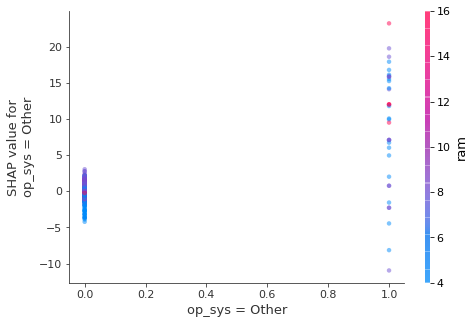

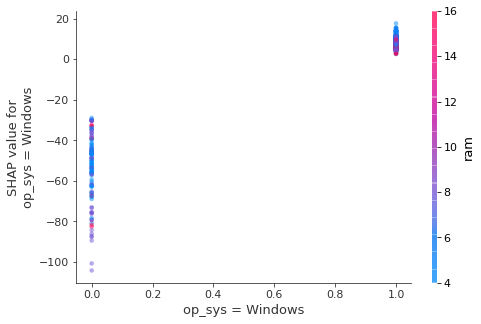

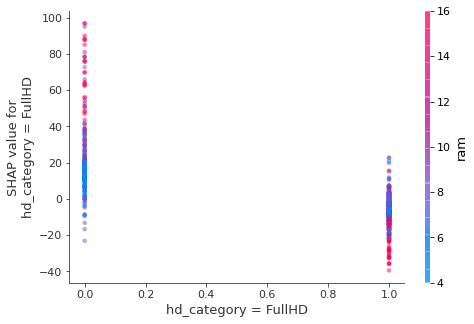

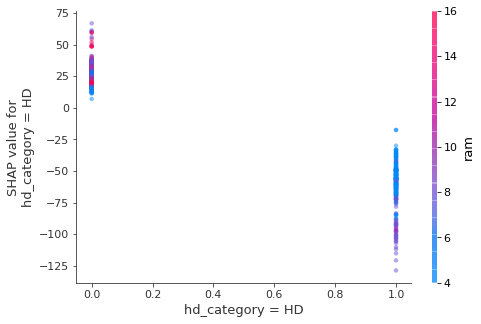

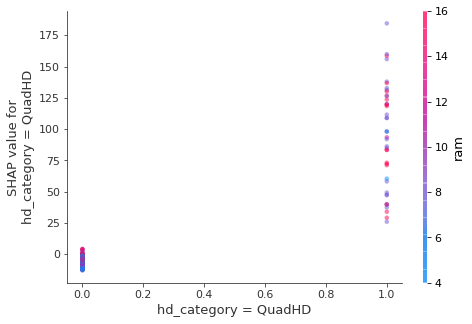

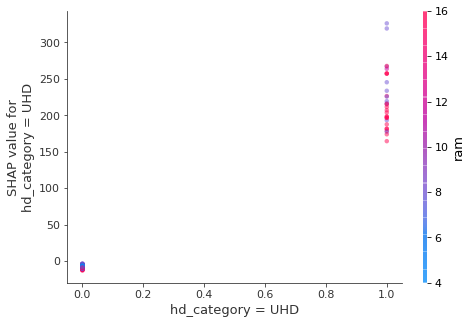

In [27]:
for name in X_train.columns:
    shap.dependence_plot(name, xgb_shap_values, X_train, dot_size = 20, alpha = 1/2, interaction_index = 'ram')

#### 3. Prediction explanation plots

Visualize 1 or more prediction's explanation

In [28]:
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[0,:], X_train.iloc[0,:]) #plot_cmap=['#32CD32', '#B22222'])

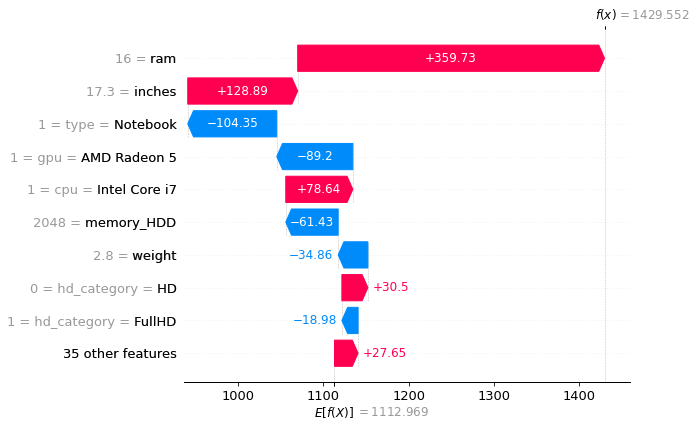

In [34]:
shap.plots._waterfall.waterfall_legacy(xgb_explainer.expected_value, xgb_shap_values[0], 
                                       features = X_train.iloc[0,:])

In [35]:
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[0:1000,:], X_train.iloc[0:1000,:]) #plot_cmap=['#32CD32', '#B22222'])

Use decision plots

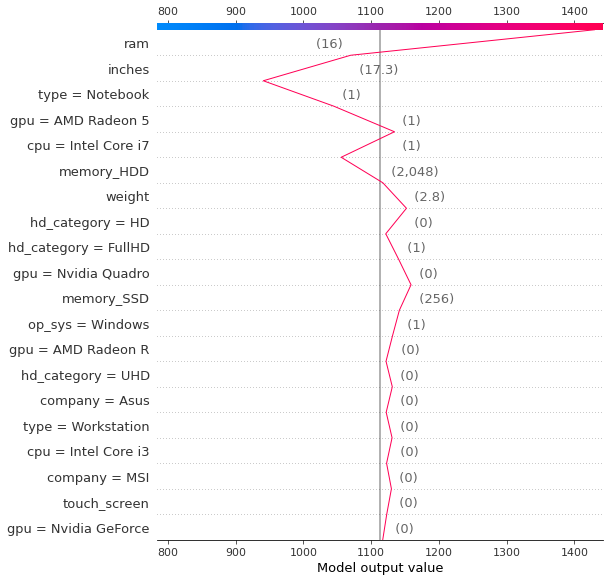

In [36]:
shap.decision_plot(xgb_explainer.expected_value, xgb_shap_values[0,:], 
                   features = X_train.iloc[0,:], )

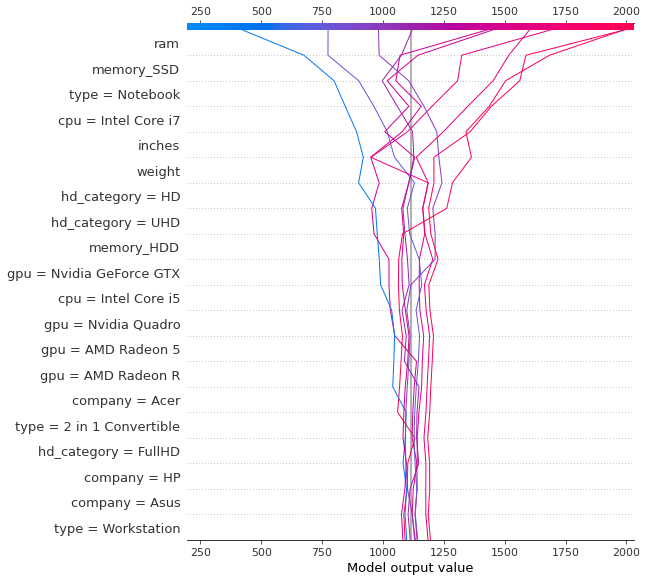

In [37]:
shap.decision_plot(xgb_explainer.expected_value, xgb_shap_values[0:10,:], 
                   features = X_train.iloc[0:10,:])